# Pyturbseq

`pyturbseq` is a tool for analysis of single cell functional genomics and perturbation data.

This tutorial describes the basic usage of Pyturbseq. It is assumed that the user has already installed Pyturbseq and its dependencies. If not, please refer to the installation instructions.


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Single Cell QC

In [2]:
## this is the path to the cellranger output. If you have multiple lanes, you would run this for each lane
cellranger_base_path = '/data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs'
gex_path = f'{cellranger_base_path}/filtered_feature_bc_matrix.h5'
guide_calls_path = f'{cellranger_base_path}/crispr_analysis/protospacer_calls_per_cell.csv'

## Option 1: Load Gene Expression and Guide Call directly (Recommended)

Cellranger provides sgRNA calls and analysis when running `cellranger count` with a feature library.  
pyturbseq calling is on par with cellranger and vice versa.  
This is recommended simply because it has already been run by cellranger if you used cellranger to count your sgRNAs. No need to spend compute on rerunning.   

In [3]:
from pyturbseq.cellranger import parse_CR_h5, add_CR_sgRNA
from pyturbseq.utils import split_by_feature_type

#read gene expression h5 and add cellranger guide calls
#Note: this is 
adata = parse_CR_h5(
    gex_path,
    guide_calls_path
    )
adata.obs.head()

## Alternate if you already have a loaded adata object
#get CR sgRNA assignment for list of cell barcodes
# add_CR_sgRNA(
#     adata,
#     crispr_out,
#     inplace=True
#     )

Reading /data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs/filtered_feature_bc_matrix.h5
Adding guide calls
Reading /data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs/crispr_analysis/protospacer_calls_per_cell.csv
Found sgRNA information for 6896/9188 (75.05%) of cell barcodes
Finished reading adata with 9188 cells and 36859 genes


/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,num_features,feature_call,num_umis
AAACCCAAGCACGGAT-1,2.0,DCPS_A|CUL5_A,986|1635
AAACCCAAGGATACAT-1,NaN,NaN,NaN
AAACCCAAGGTAGACC-1,1.0,NTC_D,943
AAACCCACAGATACTC-1,1.0,ERCC6_A,777
AAACCCAGTCGTGGAA-1,NaN,NaN,NaN


## Option 2: Custom Guide Calling

`pyturbseq` using a GMM to call guides from counts.   
Note: this requires that you have guide counts! This example assumes guide counts are included via the gex_only=False option mentioned above

In [41]:
from pyturbseq.calling import call_features, calculate_feature_call_metrics
from pyturbseq.utils import split_by_feature_type
from pyturbseq.plot import plot_top2ratio_counts, plot_num_features

adata = sc.read_10x_h5(
    gex_path,
    gex_only=False ## This argument optionally includes the sgRNA counts if set to False. 
    ## Not necessary if you are using cellrangers guide calls but recommended to save the guide counts as well if further QC is required.
    ) 
adata.var_names_make_unique()
adata.obs_names_make_unique()

adata.var['feature_types'].value_counts()

/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


feature_types
Gene Expression         36601
CRISPR Guide Capture      258
Name: count, dtype: int64

In [42]:
#call features 
call_features(adata, feature_type='CRISPR Guide Capture', n_jobs=20, inplace=True, quiet=False, subset=False, nonzero=False)
adata.obs.head(2)

Subsetting features to CRISPR Guide Capture...
Running GMM with 20 workers...


40it [00:00, 309.97it/s]

258it [00:02, 125.42it/s]


max count (0.0) is less than calling_min_count (1). Returning no calls.
Updating AnnData object with guide calls...


,num_features,feature_call
AAACCCAAGCACGGAT-1,2,DCPS_A|CUL5_A
AAACCCAAGGATACAT-1,0,


## Adding additional guide call metrics

In [43]:
calculate_feature_call_metrics(adata, feature_type='CRISPR Guide Capture', inplace=True)

/data_gilbert3/awinters/projects/pyturbseq/pyturbseq/calling.py:139: RuntimeWarning: invalid value encountered in divide
  features.obs['ratio_2nd_1st_feature'] = (X[:,-2]) / (X[:,-1])
/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data_gilbert3/awinters/projects/pyturbseq/pyturbseq/calling.py:145: RuntimeWarning: invalid value encountered in divide
  prop_topN = topN.sum(axis=1) / X.sum(axis=1)
/data_gilbert3/awinters/projects/pyturbseq/pyturbseq/calling.py:145: RuntimeWarning: invalid value encountered in divide
  prop_topN = topN.sum(axis=1) / X.sum(axis=1)


## Visualizing and Annotating guide calls

### Assigning confident calls to 'perturbation' column

Here we do some further filtering and formating for confident guide calls. 
While cellranger guide calls tend to be fairly good, this data is still unfiltered. 

Additionally, it is favorable to format the guide call. This can be to directly map the guide call to a gene, to merge multi gene perturbations with different order, and to format guides for downstream analysis like DESeq2.

There are a few relevant scenarios listed for the expected case of 1 construct per cell:
- Single sgRNA 
- Dual sgRNA targeting SAME gene
- Dual sgRNA targeting DIFFERENT genes (currently not shown below)

#### Dual sgRNA targeting SAME gene

In [44]:
##NOTE: 
# this datatset is single construct so we artificially create the feature calls to demonstrate dual guide 
# We add '_1' and '_2' to indicate a positional annotation common (and recommended) for dual guide experiments

##EXCLUDE FOR DATA THAT IS ALREADY DUAL GUIDE
adata_dual = adata[adata.obs['num_features'] == 1, :].copy()
adata_dual.obs['feature_call'] = adata_dual.obs['feature_call'] + '_1' + '|' +  adata_dual.obs['feature_call'] + '_2'
adata_dual.obs['num_features'] = adata_dual.obs['num_features'] * 2 
adata_dual.obs.head(2)
##EXCLUDE FOR DATA THAT IS ALREADY DUAL GUIDE

,num_features,feature_call,total_feature_counts,log1p_total_feature_counts,log10_total_feature_counts,ratio_2nd_1st_feature,log2_ratio_2nd_1st_feature,pct_top1_features,pct_top2_features
AAACCCAAGGTAGACC-1,2,NTC_D_1|NTC_D_2,946.0,6.853299,2.97635,0.001060,-9.881114,99.682877,99.788582
AAACCCACAGATACTC-1,2,ERCC6_A_1|ERCC6_A_2,784.0,6.665684,2.89487,0.002574,-8.601770,99.107140,99.362244


In [45]:
#uncomment for actually dual guide data here to see the guide count distribution
# g = plot_num_features(adata_dual, show=True) 
# g = plot_top2ratio_counts(adata_dual, show=True)

In [46]:
from pyturbseq.calling import parse_dual_guide

parse_dual_guide(
    adata_dual,
    inplace=True,
    position_annotation=['A', 'B'],
    # library_reference= ... #path to a reference library with sgRNA_A or sgRNA_B in the feature names that indicate guide pairs in the library.
    )

perturbed_cells = adata_dual.obs['perturbation'] != 'NTC'
adata_dual.obs.loc[perturbed_cells, 'target_gene']  = adata_dual.obs.loc[perturbed_cells, 'perturbation'] # in this case, the target gene is all perturbations that are not the non targeting control (NTC)
adata_dual.obs.head()

Dual guide same target found, collapsing to same target..


,num_features,feature_call,total_feature_counts,log1p_total_feature_counts,log10_total_feature_counts,ratio_2nd_1st_feature,log2_ratio_2nd_1st_feature,pct_top1_features,pct_top2_features,sgRNA_fullID_A,sgRNA_fullID_B,sgRNA_A,sgRNA_B,perturbation_fullID,perturbation_status,perturbation,target_gene
AAACCCAAGGTAGACC-1,2,NTC_D_1|NTC_D_2,946.0,6.853299,2.976350,0.001060,-9.881114,99.682877,99.788582,NTC_D_1,NTC_D_2,NTC,NTC,NTC_D_1|NTC_D_2,NaN,NTC,NaN
AAACCCACAGATACTC-1,2,ERCC6_A_1|ERCC6_A_2,784.0,6.665684,2.894870,0.002574,-8.601770,99.107140,99.362244,ERCC6_A_1,ERCC6_A_2,ERCC6,ERCC6,ERCC6_A_1|ERCC6_A_2,NaN,ERCC6,ERCC6
AAACCCAGTGAATAAC-1,2,STK40_A_1|STK40_A_2,1441.0,7.273787,3.158966,0.001392,-9.488844,99.722412,99.861206,STK40_A_1,STK40_A_2,STK40,STK40,STK40_A_1|STK40_A_2,NaN,STK40,STK40
AAACCCAGTTGTGTAC-1,2,ZEB2_A_1|ZEB2_A_2,1105.0,7.008505,3.043755,0.001817,-9.104599,99.638008,99.819008,ZEB2_A_1,ZEB2_A_2,ZEB2,ZEB2,ZEB2_A_1|ZEB2_A_2,NaN,ZEB2,ZEB2
AAACCCATCAGCGGAA-1,2,CUL5_A_1|CUL5_A_2,1484.0,7.303170,3.171727,0.000000,-inf,100.000000,100.000000,CUL5_A_1,CUL5_A_2,CUL5,CUL5,CUL5_A_1|CUL5_A_2,NaN,CUL5,CUL5


####  Single sgRNA

##### Check the distribution of # of guide calls per cell

For single guide cases, we expect to see a majority of cells with 1 guide. 
For dual guide cases, we expect to see a majority of cells with 2 guides. 

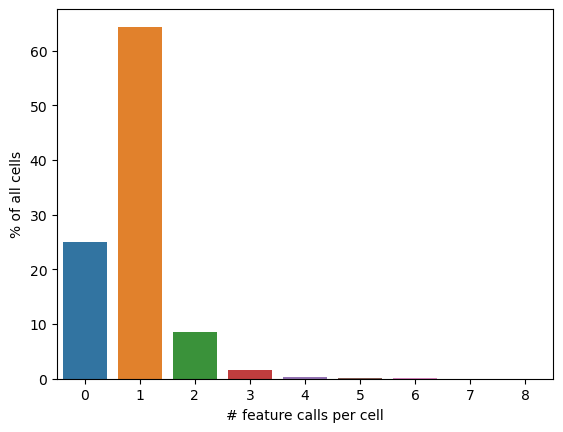

In [47]:
g = plot_num_features(adata, show=True)

In [4]:
adata.obs['perturbation'] =  None ## confident guide assignment column

## assign guide to a cel=s ONLY if they have 1 guide called
adata.obs.loc[adata.obs['num_features'] == 1, 'perturbation'] = adata.obs.loc[adata.obs['num_features'] == 1, 'feature_call']

adata.obs['guide'] = adata.obs['perturbation'] #store the original guide name for downstream analysis 
adata.obs['perturbation'] = adata.obs['perturbation'].str.replace('NTC_[A-Z]', 'NTC', regex=True).str.split('_').str[0] #merge all the NTCs into one perturbation class
# adata.obs['perturbation'] = adata.obs['perturbation'].str.replace('_', '-') #make it friendly with DEseq2 which does not accept underscores for some reason
adata.obs['target_gene']  = adata.obs['guide'].str.split('_').str[0] #get a target gene for each. In this case is just the name of the guide
adata.obs.loc[adata.obs['perturbation'] == 'NTC', 'target_gene'] = None #set NTC target gene to None

adata.obs.head(5)

,num_features,feature_call,num_umis,perturbation,guide,target_gene
AAACCCAAGCACGGAT-1,2.0,DCPS_A|CUL5_A,986|1635,None,None,None
AAACCCAAGGATACAT-1,NaN,NaN,NaN,None,None,None
AAACCCAAGGTAGACC-1,1.0,NTC_D,943,NTC,NTC_D,None
AAACCCACAGATACTC-1,1.0,ERCC6_A,777,ERCC6,ERCC6_A,ERCC6
AAACCCAGTCGTGGAA-1,NaN,NaN,NaN,None,None,None


### Filter to confident guide calls

In [5]:
print(f"{np.sum(adata.obs['perturbation'].notna())}/{adata.shape[0]} cells have a guide assignment")
adata = adata[adata.obs['perturbation'].notna(), :] #remove cells that do not have a guide assignment
adata.obs.head(2)

5913/9188 cells have a guide assignment


,num_features,feature_call,num_umis,perturbation,guide,target_gene
AAACCCAAGGTAGACC-1,1.0,NTC_D,943,NTC,NTC_D,None
AAACCCACAGATACTC-1,1.0,ERCC6_A,777,ERCC6,ERCC6_A,ERCC6


### Output confident guide assigned gene expression and guide counts if desired

In [6]:
#currently we have multiple feature types in adata.X
adata.var['feature_types'].value_counts()

feature_types
Gene Expression         36601
CRISPR Guide Capture      258
Name: count, dtype: int64

In [7]:
#split anndata into gex and sgRNA
out = split_by_feature_type(adata)
adata = out['Gene Expression']
adata_sgRNA = out['CRISPR Guide Capture']

## save processed anndata. 

# adata.write_h5ad('gex.h5ad')
# adata_sgRNA.write_h5ad('sgRNA.h5ad')

## Single cell filtering via Scanpy

General QC and filtering of single cell data based on gene expression.

Please refer to the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) for more up to date filtering practices.

/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


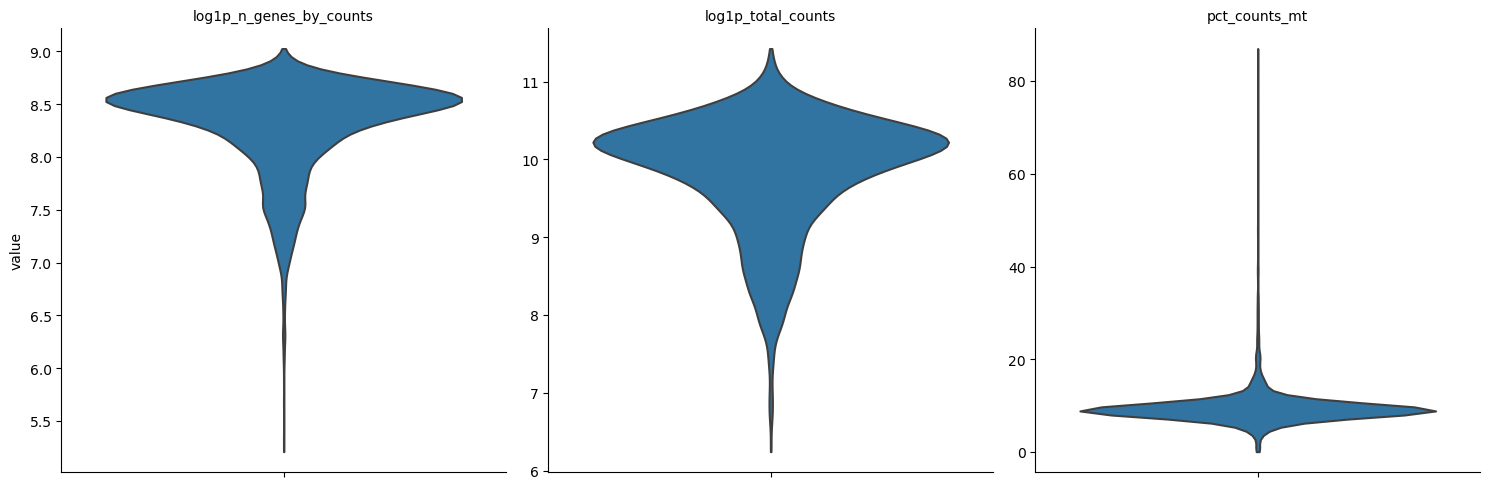

In [8]:
#add mito gene content and scanpy metrics (most importantly n_genes_by_counts and total_counts)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

#plot QC metrics to determine filtering cutoffs
sc.pl.violin(adata, ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'], stripplot=False, multi_panel=True)

### Filter cells based on QC metrics
We do provide a couple functions for easy filtering but this should be done manually and is dependent on the dataset. 


In [9]:
from pyturbseq.utils import filter_adata

#this function provides a way to list multiple filters for cells (obs) and genes (var)
adata = filter_adata(
    adata,
    obs_filters=[
        "n_genes_by_counts > 2000",
        "pct_counts_mt < 20",
        "total_counts > 6000",
    ],
    var_filters=[
        'n_cells_by_counts > 50',
        'total_counts > 100'
    ]
    )
adata

View of AnnData object with n_obs × n_vars = 5254 × 12041
    obs: 'num_features', 'feature_call', 'num_umis', 'perturbation', 'guide', 'target_gene', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Perturbation QC

Here we calculate several QC metrics: 

Single cell level:
- `Pct change in target gene` (established metric for CRISPR KD screens)
- `Zscore of target gene` compared to reference (recommended as it accounts for variability in reference population)

Additional Perturbation class level:
- `Number of cells per perturbation`
- `Total counts per perturbation`

Note: this below is the workflow for a single perturbation per cell. These functions can all accomodate multiple perturbations but inputs and plots would be different.

In [10]:
from pyturbseq.utils import calculate_target_change

calculate_target_change(
    adata,
    'perturbation',
    'NTC',
    # perturbation_gene_map=dict(zip(adata.obs['perturbation'], adata.obs['target_gene'])) , #optionally can provide a mapping between perturbations and target genes, not necessary in this case
    check_norm=True, #default option to check if the data is normalize. If not, normalize
    inplace=True, #default option
    )

Computing percent change for 'perturbation' across 5254 cells...
	Checking if data is normalized to counts per cell...
	Data is not normalized to counts per cell. Normalizing...
	Computing percent change for each cell...
	Generating perturbation matrix from 'perturbation' column...
Found 248 unique features.
	Found 247 unique perturbations in perturbation column.
	Missing 10 perturbations not found in adata.var_names.


100%|██████████| 247/247 [00:01<00:00, 199.96it/s]


No cells with more than 1 perturbation. Adding to .obs...


/data_gilbert3/awinters/projects/pyturbseq/pyturbseq/utils.py:377: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  final_adata.obs['target_reference_mean'] = reference_means[np.argmax(pm.values, axis=1)]


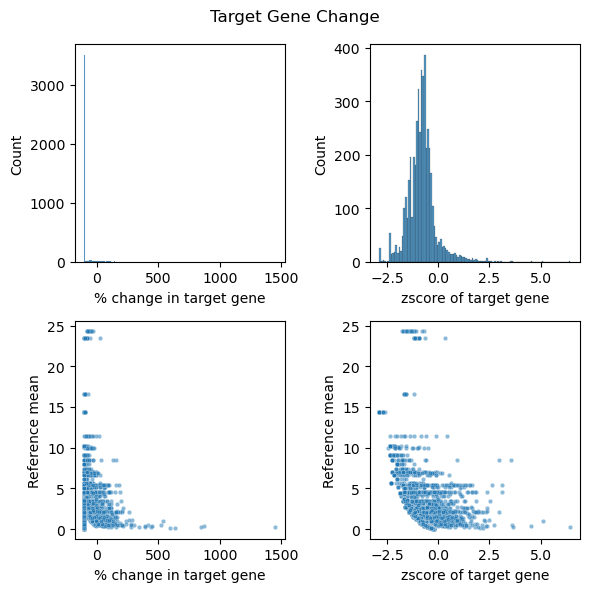

In [55]:
#visualize target knockdown at the single cell level
#We also visualize target knockdown as a function of the reference population mean

fig, ax = plt.subplots(2,2, figsize=(6, 6))
for i, (x, label) in enumerate([('target_pct_change', '% change in target gene') , ('target_zscore', 'zscore of target gene')]):
    sns.histplot(adata.obs[x], ax=ax[0, i])
    ax[0, i].set_xlabel(label)
    sns.scatterplot(x=adata.obs[x], y=adata.obs['target_reference_mean'], ax=ax[1, i], alpha=0.5, s=10)
    ax[1, i].set_xlabel(label)
    ax[1, i].set_ylabel('Reference mean')
fig.suptitle('Target Gene Change')
fig.tight_layout()
plt.show()

/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


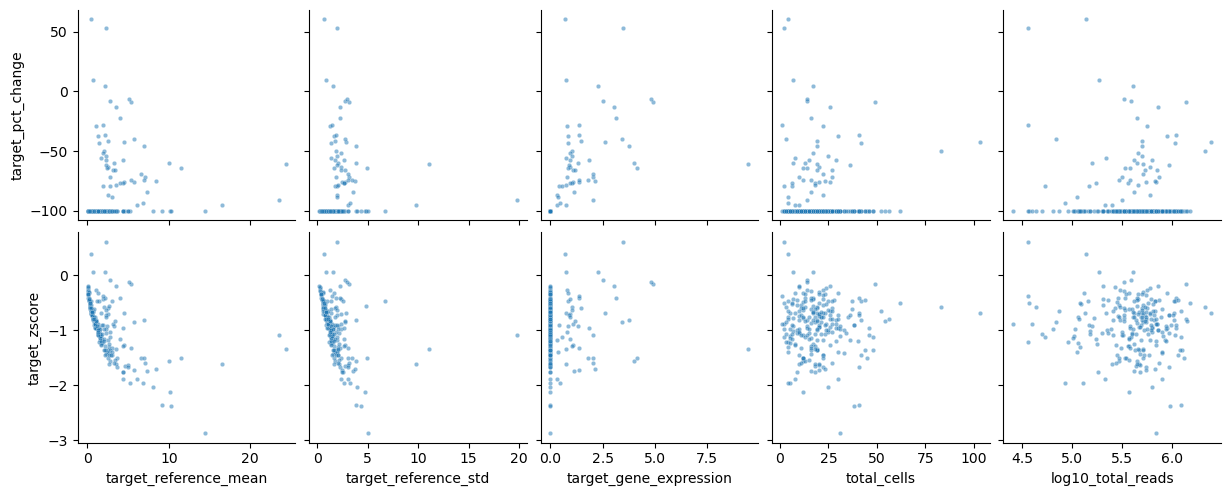

In [56]:
perturbations = adata.obs.groupby('perturbation')[['target_reference_mean', 'target_reference_std', 'target_gene_expression', 'target_pct_change', 'target_zscore']].median()
#count up total cells and total reads for each perturbation
perturbations['total_cells'] = adata.obs.groupby('perturbation')['perturbation'].count()
perturbations['log10_total_reads'] = np.log10(adata.obs.groupby('perturbation')['total_counts'].sum())

sns.pairplot(
    perturbations,
    y_vars=['target_pct_change', 'target_zscore'],
    x_vars=['target_reference_mean', 'target_reference_std', 'target_gene_expression', 'total_cells', 'log10_total_reads'],
    plot_kws=dict(alpha=0.5, s=10)
    )
plt.show()

### Visualize heatmap of target knockdown


Calculating target gene heatmap for perturbation column...
	Generating perturbation matrix from 'perturbation' column...
Found 248 unique features.
	Found 247 unique perturbations in perturbation column.
	Missing 10 perturbations not found in adata.var_names.


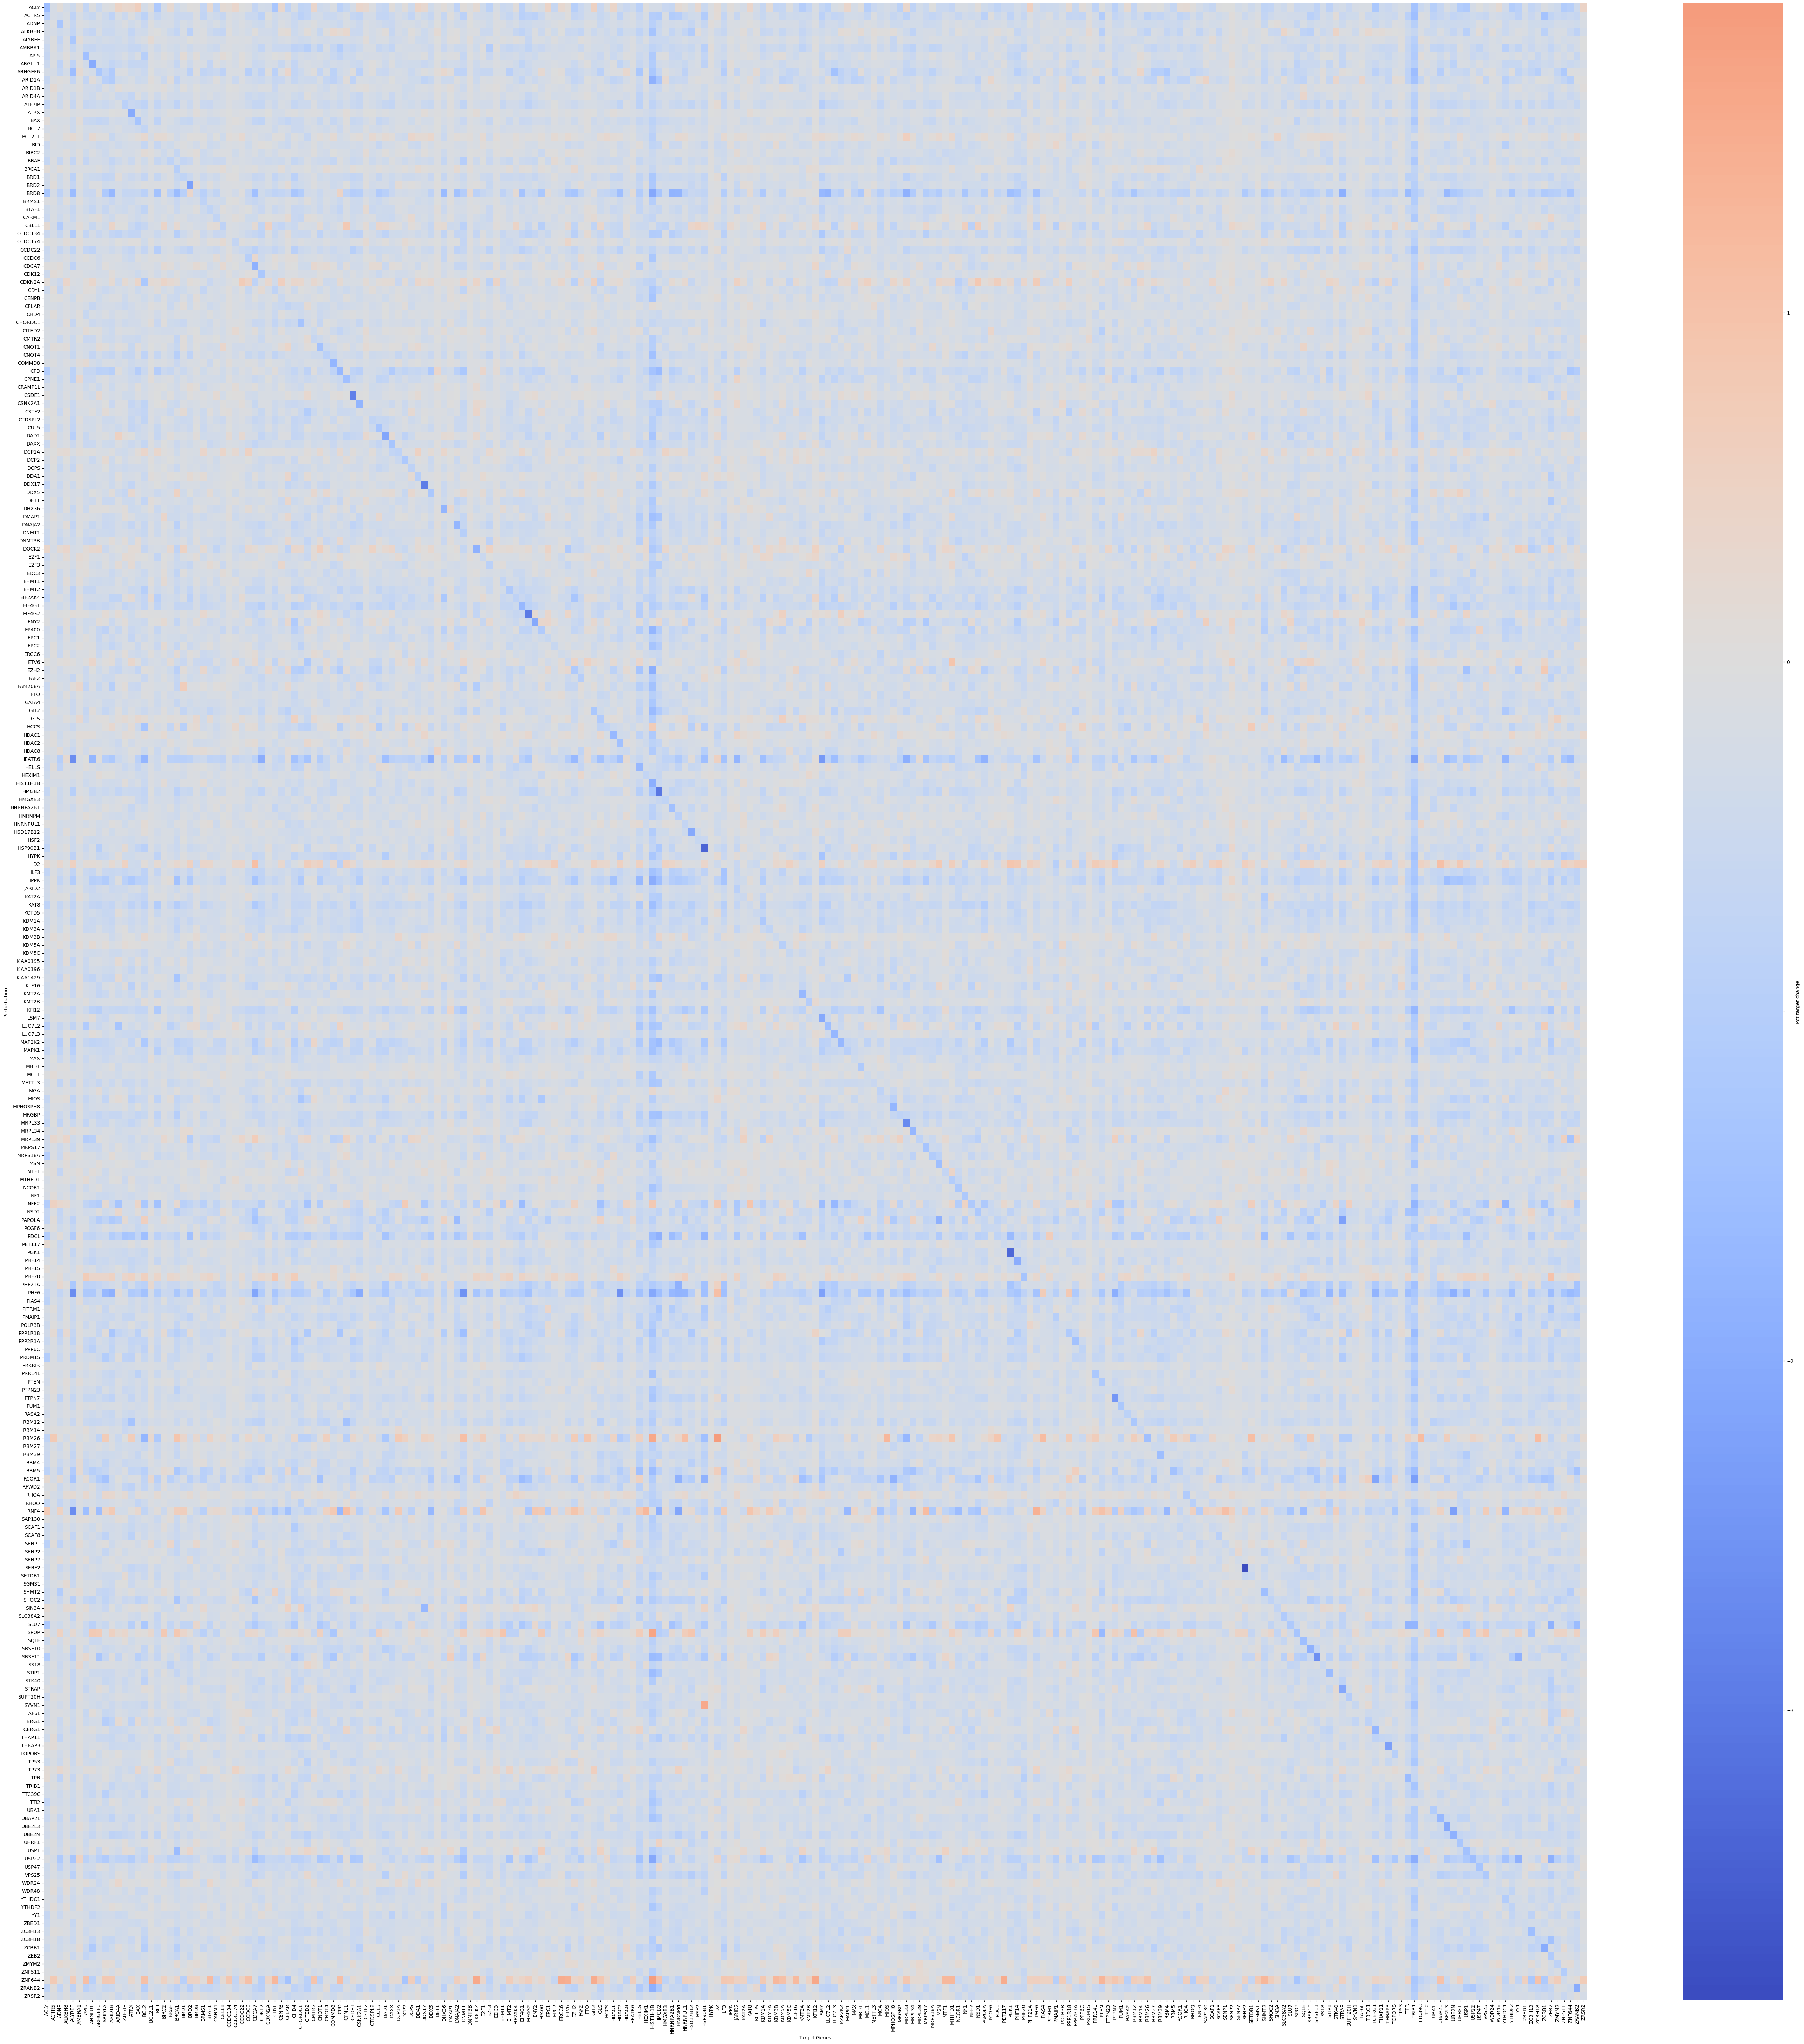

In [15]:
from pyturbseq.plot import target_gene_heatmap

target_gene_heatmap(
    adata,
    'NTC',
    perturbation_column='perturbation',
    method='log2FC',
    )

### Optional: Filter cells or perturbation classes based on target knockdown

This is an optional step as filtering is very case dependent. In most current work, this is not on a cell level but rather at the perturbation class level.

In [57]:
## filter out cells that dont have at least 10% KD
adata = adata[adata.obs['target_pct_change'] < -10, :].copy()
adata

AnnData object with n_obs × n_vars = 4326 × 12041
    obs: 'num_features', 'feature_call', 'total_feature_counts', 'log1p_total_feature_counts', 'log10_total_feature_counts', 'ratio_2nd_1st_feature', 'log2_ratio_2nd_1st_feature', 'pct_top1_features', 'pct_top2_features', 'perturbation', 'guide', 'target_gene', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'target_reference_mean', 'target_reference_std', 'target_pct_change', 'target_zscore', 'target_log2fc', 'target_gene_expression'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'features'
    obsm: 'calls'

# Analysis

## Perturbation analysis

We recommend at this point to still maintain raw counts per cell. 
This is primarily for the ability to pseudobulk cells to eeach perturbation class and any relevant covariates (ie 10x lane, treatment, patient, etc.)

### Pseudobulk 

The pseudobulk function is a wrapper on [ADPBulk](https://github.com/noamteyssier/adpbulk) by Noam Teyssier. Credit to him for a great and efficient tool! 

In [58]:
from pyturbseq.utils import pseudobulk

pb = pseudobulk(
    adata,
    ['perturbation'],
    method='sum' #default and recommended method for pseudobulk adds all counts for all sums in each covariate group.
    )


#for downstream analysis its recomomended to pseudobulk and all relevant covariates
# pb = pseudobulk(
#     adata,
#     ['treatment', 'perturbation', 'lane'],
#     method='mean' #default and recommended method for pseudobulk
#     )

#remove any genes that are not expressed in at least 10% of cells

pb

Aggregating Samples: 100%|██████████| 237/237 [00:00<00:00, 1290.69it/s]


AnnData object with n_obs × n_vars = 237 × 12041
    obs: 'perturbation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Differential Expression Analysis

We and others recommend pseudobulking to each perturbation and then to relevant technical (10x lane) or biological covariates (patient).

Some resources on this here: 
- https://www.nature.com/articles/s41467-021-25960-2


**NOTE** It is recommended to not run this in Jupyter notebook and instead run in the background as a script.

In [ ]:
from pyturbseq.de import get_all_degs

#from pyturbseq.de import get_all_degs 
## we do provide a parallelized function however it is currently untested on different machines so recommend the synchronous version
degs = get_all_degs(
    pb, 'perturbation', 'NTC',
    n_cpus=28,
    # max_workers=5,
    # quiet=False
    )

## Perturbation Similarity Analysis

### Pairwise Cosine Similarity


In [59]:
#first do some basic filtering and normaliztion
sc.pp.normalize_total(pb, target_sum=1e4)
sc.pp.log1p(pb)

#optional subset to HVGs for better separation of perturbation
sc.pp.highly_variable_genes(pb, n_top_genes=500,subset=True)
pb

AnnData object with n_obs × n_vars = 237 × 500
    obs: 'perturbation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

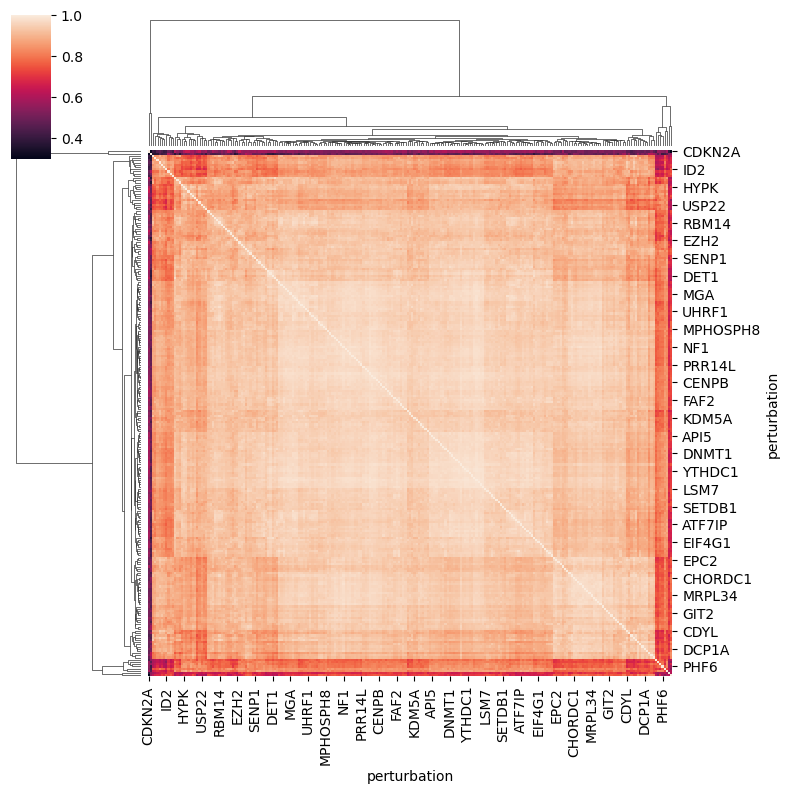

In [60]:
from scipy.spatial.distance import pdist, squareform

pairwise_correlation = 1-squareform(pdist(pb.X, metric='correlation')) #calculate cosine distance and convert to similarity by subtracting from 1
pairwise_correlation = pd.DataFrame(pairwise_correlation, index=pb.obs['perturbation'], columns=pb.obs['perturbation'])

sns.clustermap(pairwise_correlation, figsize = (8, 8))
plt.show()

From here you can cluster perturbations into similar groups and proceed with custom analysis. 

## Traditional Processing and Visualization of single cell data

While this notebook is meant to focus on the analysis of perturbation data, traditional single cell analysis is still relevant.


In [61]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

In [62]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data_gilbert/home/awinters/bin/ma

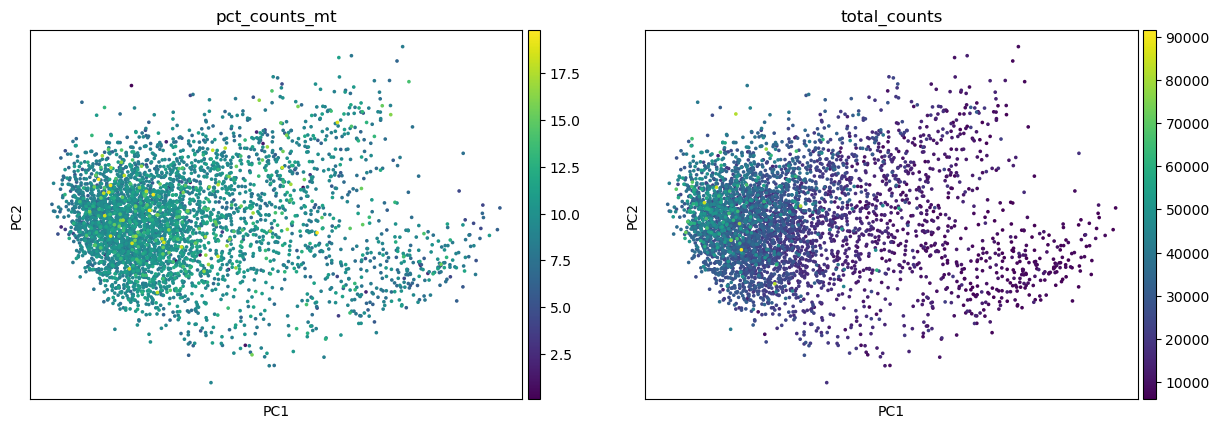

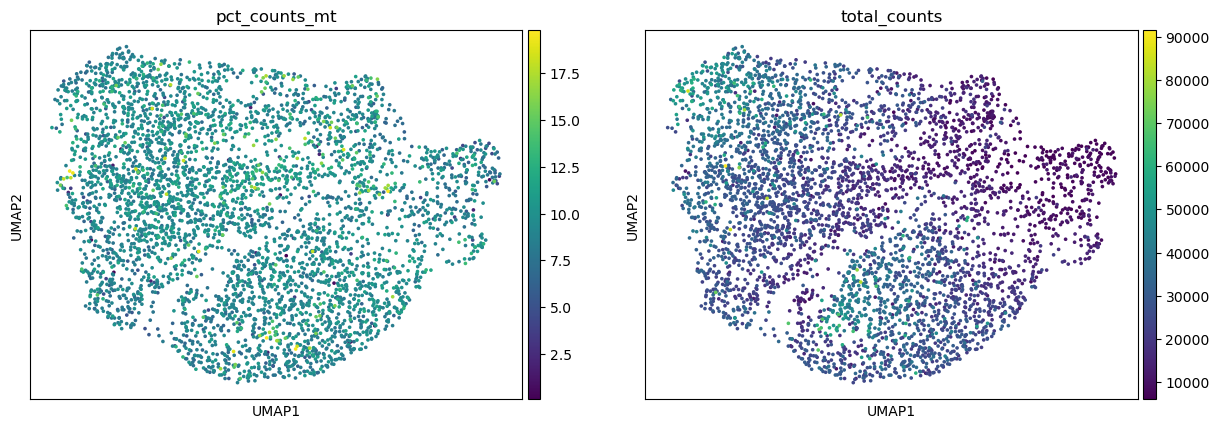

In [63]:
sc.pl.pca(adata, color=['pct_counts_mt','total_counts'])
sc.pl.umap(adata, color=['pct_counts_mt','total_counts'], ncols=3)

## Correction of gene expression counts/embedding for batch effect

Here you could additionally correct for batch effect if desired.
We recommend using [Harmony](https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html) for efficient and effective batch correction across most use cases. 